In [42]:
import pandas as pd
import numpy as np

historydf= pd.read_csv("MSFTafter2008.csv", index_col=0)
historydf.dropna(how='any',inplace=True)

In [43]:
from sklearn import preprocessing

def normalize(df):
    newdf= df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    
    newdf['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    newdf['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    newdf['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    newdf['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    newdf['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    newdf['adjclose'] = min_max_scaler.fit_transform(df.adjclose.values.reshape(-1,1))
    
    return newdf

historydf_norm= normalize(historydf)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [44]:
historydf_norm=historydf_norm.astype('float32')

In [45]:
def data_split(data,sample):
    # 資料維度: 開盤價、收盤價、最高價、最低價、成交量... 6維
    feature = len(data.columns)
    
    # 將dataframe 轉成 numpy array
    data = data.as_matrix()
    newdata = []
    y_data = []
    # 若想要觀察的 time_frame 為20天, 需要多加一天做為驗證答案
    for i in range(len(data)-sample):# 從 datavalue 的第0個跑到倒數第 time_frame+1 個
        newdata.append(data[i:(i+sample)])# 逐筆取出 time_frame+1 個 K棒數值做為一筆 instance
        y_data.append(data[i+sample,-1:])
        
    n_train = round(0.8*len(newdata))# 取 result 的前 80% instance做為訓練資料
    newdata = np.array(newdata)
    
    x_train = newdata[:int(n_train)] 
    y_train = y_data[:int(n_train)] # 訓練資料中, 取每一個 time_frame 中最後一筆資料的最後一個數值(收盤價)做為答案
    x_test = newdata[int(n_train):]
    y_test = y_data[int(n_train):]

    # 將資料組成變好看一點
    x_train = x_train.reshape(-1, 20, 6)
    x_test = x_test.reshape(-1, 20, 6)
    return x_train,np.array(y_train), x_test, np.array(y_test)

# 以30天為一區間進行股價預測
x_train,y_train,x_test,y_test= data_split(historydf_norm,20)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [46]:
x_train.shape


(2057, 20, 6)

In [47]:
len(y_train)


2057

In [48]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch as t
from torch import nn
from torch.autograd import Variable

In [49]:
x_train = t.from_numpy(x_train)
y_train = t.from_numpy(y_train)
x_test = t.from_numpy(x_test)
y_test = t.from_numpy(y_test)

In [37]:
#定義模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2,dropout=0.5):
            super(lstm_reg, self).__init__()
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers,dropout=dropout)
            self.reg = nn.Linear(20*hidden_size, output_size)
          
    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state
        r_out = r_out.reshape(r_out.shape[0], r_out.shape[1]*r_out.shape[2])
        #r_out = t.sin(r_out)
        out = self.reg(r_out)
        return out
net = lstm_reg(6, 64)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
for e in range(100):
    var_x = Variable(x_train)
    var_y = Variable(y_train)
 
    out = net(var_x)
    print(out.shape)
    loss = criterion(out, var_y)
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('Epoch: {}, Loss:{:.5f}'.format(e+1, loss.data.item()))

    if True:

        var_x = Variable(x_train)
        pred_train_pic = net(var_data_pic) # 訓練集的预测结果
        pred_train_pic = pred_train_pic.view(-1).data.numpy()
        y_train_pic = y_train.view(-1).data.numpy()


        plt.figure(figsize=(5,2))
        plt.plot(pred_train_pic, 'r', label='train_prediction')
        plt.plot(y_train_pic, 'b', label='real')
        plt.title("train{}_prediction".format(e))
        plt.legend(loc='best')
        #plt.savefig("JPM_train_drop0.5_epoch_100.jpg")
        plt.text(0, 0.8, 'Epoch: {}, Loss:{:.5f}'.format(e+1, loss.item()), fontdict={'size': 10, 'color':  'red'})
        plt.pause(0.1)

        var_data_pic = Variable(x_test)
        pred_test_pic = net(var_data_pic) # 测试集的预测结果
        pred_test_pic = pred_test_pic.view(-1).data.numpy()
        y_test_pic = y_test.view(-1).data.numpy()

        def denormalize(df, norm_value):
            original_value = df['close'].values.reshape(-1,1)
            norm_value = norm_value.reshape(-1,1)
    
            min_max_scaler = preprocessing.MinMaxScaler()
            min_max_scaler.fit_transform(original_value)
            denorm_value = min_max_scaler.inverse_transform(norm_value)
    
            return denorm_value


        denorm_pred = denormalize(historydf, pred_test)
        denorm_ytest = denormalize(historydf, y_test)
        plt.plot(denorm_pred, 'r', label='prediction')
        plt.plot(denorm_ytest, 'b', label='real')
        plt.legend(loc='best')
        plt.show()
        plt.figure(figsize=(5,2))
        plt.plot(pred_test_pic, 'r', label='test_prediction')
        plt.plot(y_test_pic, 'b', label='real')
        plt.title("test{}_prediction".format(e))
        plt.legend(loc='best')
        #plt.savefig("JPM_test_drop0.5_epoch_100.jpg")
        plt.text(0, 0.8, 'Epoch: {}, Loss:{:.5f}'.format(e+1, loss.item()), fontdict={'size': 10, 'color':  'red'})
        plt.pause(0.1)




t.save(net.state_dict(), 'net_params.pkl')

In [38]:
for e in range(300):
    var_x = Variable(x_train)
    var_y = Variable(y_train)
 
    out = net(var_x)
    print(out.shape)
    loss = criterion(out, var_y)
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('Epoch: {}, Loss:{:.5f}'.format(e+1, loss.item()))
        
t.save(net.state_dict(), 'net_params.pkl')

torch.Size([2057, 1])
Epoch: 1, Loss:0.04217
torch.Size([2057, 1])
Epoch: 2, Loss:0.02166
torch.Size([2057, 1])
Epoch: 3, Loss:0.01254
torch.Size([2057, 1])
Epoch: 4, Loss:0.01443
torch.Size([2057, 1])
Epoch: 5, Loss:0.01908
torch.Size([2057, 1])
Epoch: 6, Loss:0.01869
torch.Size([2057, 1])
Epoch: 7, Loss:0.01533
torch.Size([2057, 1])
Epoch: 8, Loss:0.01230
torch.Size([2057, 1])
Epoch: 9, Loss:0.01106
torch.Size([2057, 1])
Epoch: 10, Loss:0.01141
torch.Size([2057, 1])
Epoch: 11, Loss:0.01235
torch.Size([2057, 1])
Epoch: 12, Loss:0.01293
torch.Size([2057, 1])
Epoch: 13, Loss:0.01271
torch.Size([2057, 1])
Epoch: 14, Loss:0.01176
torch.Size([2057, 1])
Epoch: 15, Loss:0.01046
torch.Size([2057, 1])
Epoch: 16, Loss:0.00926
torch.Size([2057, 1])
Epoch: 17, Loss:0.00851
torch.Size([2057, 1])
Epoch: 18, Loss:0.00831
torch.Size([2057, 1])
Epoch: 19, Loss:0.00843
torch.Size([2057, 1])
Epoch: 20, Loss:0.00837
torch.Size([2057, 1])
Epoch: 21, Loss:0.00775
torch.Size([2057, 1])
Epoch: 22, Loss:0.006

torch.Size([2057, 1])
Epoch: 178, Loss:0.00017
torch.Size([2057, 1])
Epoch: 179, Loss:0.00017
torch.Size([2057, 1])
Epoch: 180, Loss:0.00017
torch.Size([2057, 1])
Epoch: 181, Loss:0.00017
torch.Size([2057, 1])
Epoch: 182, Loss:0.00017
torch.Size([2057, 1])
Epoch: 183, Loss:0.00017
torch.Size([2057, 1])
Epoch: 184, Loss:0.00017
torch.Size([2057, 1])
Epoch: 185, Loss:0.00017
torch.Size([2057, 1])
Epoch: 186, Loss:0.00017
torch.Size([2057, 1])
Epoch: 187, Loss:0.00017
torch.Size([2057, 1])
Epoch: 188, Loss:0.00017
torch.Size([2057, 1])
Epoch: 189, Loss:0.00017
torch.Size([2057, 1])
Epoch: 190, Loss:0.00017
torch.Size([2057, 1])
Epoch: 191, Loss:0.00017
torch.Size([2057, 1])
Epoch: 192, Loss:0.00017
torch.Size([2057, 1])
Epoch: 193, Loss:0.00017
torch.Size([2057, 1])
Epoch: 194, Loss:0.00017
torch.Size([2057, 1])
Epoch: 195, Loss:0.00017
torch.Size([2057, 1])
Epoch: 196, Loss:0.00017
torch.Size([2057, 1])
Epoch: 197, Loss:0.00017
torch.Size([2057, 1])
Epoch: 198, Loss:0.00017
torch.Size([2

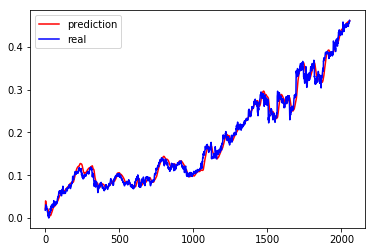

In [39]:
var_data = Variable(x_train)
pred_train = net(var_data) # 訓練集的预测结果
pred_train = pred_train.view(-1).data.numpy()
y_train = y_train.view(-1).data.numpy()
plt.plot(pred_train, 'r', label='prediction')
plt.plot(y_train, 'b', label='real')
plt.legend(loc='best')
plt.show()

In [40]:
var_data = Variable(x_test)
pred_test = net(var_data) # 测试集的预测结果
pred_test = pred_test.view(-1).data.numpy()
y_test = y_test.view(-1).data.numpy()

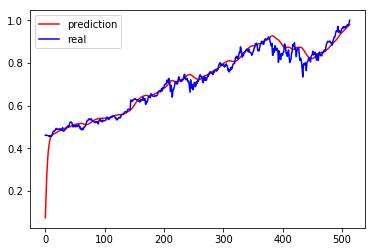

In [41]:
plt.plot(pred_test, 'r', label='prediction')
plt.plot(y_test, 'b', label='real')
plt.legend(loc='best')
plt.show()